In [1]:
# Dependencies
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import squarify
import requests
import json
import plotly.plotly as py
import gmaps
# Google API Key
from google_config import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

import gmaps.datasets


In [2]:
# Creating a dataframe from csv
df = pd.read_csv("Resources/survey_results_public.csv", low_memory=False)

In [3]:
# Cleaning the data
df_cleaned = df[['DevType','Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation',
                 'UndergradMajor','Exercise', 'Gender', 'SexualOrientation',
       'EducationParents', 'RaceEthnicity', 'Age','YearsCodingProf']]


In [4]:
# Geography
# Map of developers from each country
df_developer_country = pd.DataFrame()
df_developer_country['Country'] = df_cleaned['Country'].value_counts().index
df_developer_country['Count'] = df_cleaned['Country'].value_counts().values
df_developer_country.dropna(how='any')
df_developer_country.head()

,Country,Count
0,United States,20309
1,India,13721
2,Germany,6459
3,United Kingdom,6221
4,Canada,3393


In [5]:
df_code = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
for index, row in df_developer_country.iterrows():
    country = row['Country']
    for index2, row2 in df_code.iterrows():
        if country == row2['COUNTRY']:
            df_developer_country.loc[index, "Code"] = row2['CODE']
df_developer_country.dropna()


In [6]:
df = df_developer_country

data = [ dict(
        type = 'choropleth',
        locations = df['Code'],
        z = df['Count'],
        text = df['Country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of Developers'),
      ) ]

layout = dict(
    title = 'Total Developers By Country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        autosize=True
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='developers-world-map' )

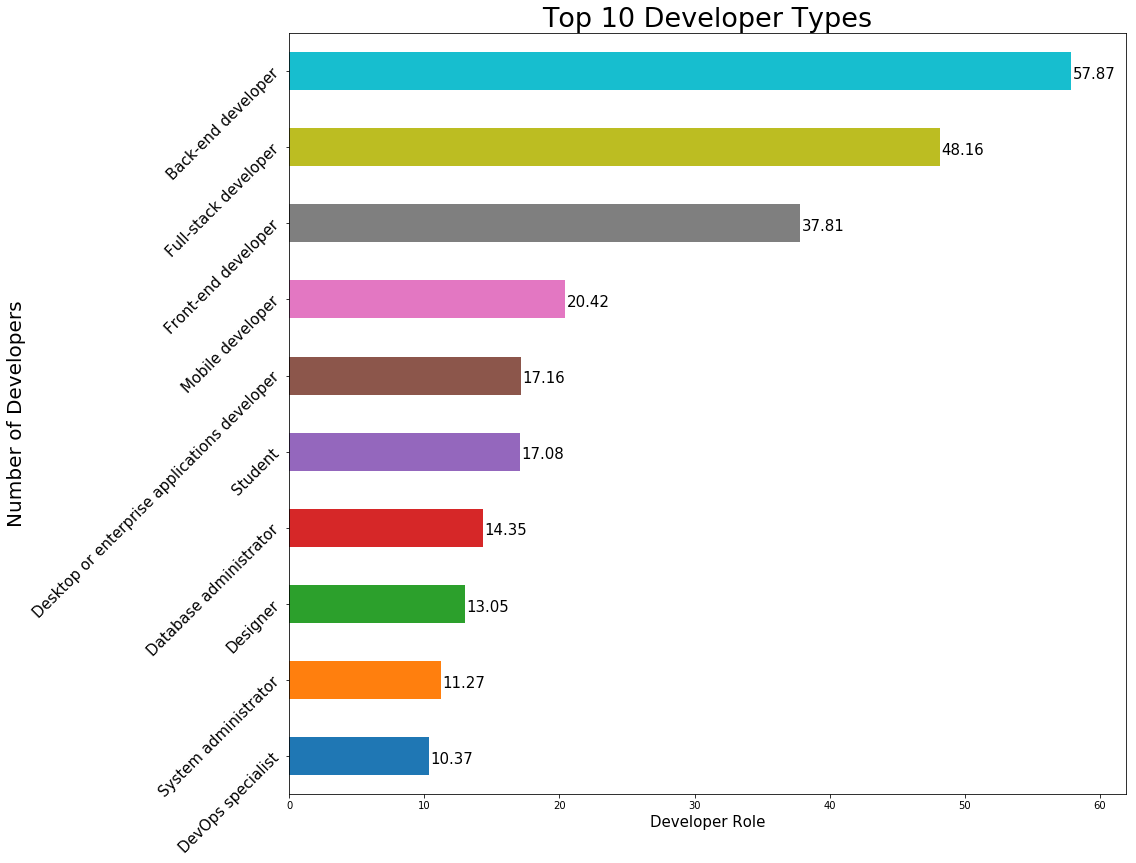

In [7]:
dev_type = df_cleaned['DevType'].dropna()
dev_role = {}
for roles in dev_type:
    role_list= roles.split(';')
    for role in role_list:
        dev_role[role] = (dev_role.get(role, 0)+1) 
dev_role_df = pd.DataFrame.from_dict(dev_role, orient='index', columns=['Number of Developers'])
total_developers = dev_type.count()

dev_role_df['Percentage'] = round(dev_role_df['Number of Developers']/total_developers*100,2)
explode = (0.1,0,0,0,0)
plt.figure(figsize=(15,14))
plt.margins(.07,.07)
dev_list = dev_role_df['Percentage'].sort_values(ascending=False)
ax = dev_list[:10].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Developer Types',fontsize=27)
plt.xlabel('Developer Role',fontsize=15)
plt.yticks(fontsize=15, rotation=45)
plt.ylabel('Number of Developers',fontsize=20)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=15, color='black')

    
plt.savefig("Images/Top10DeveloperTypes.png")

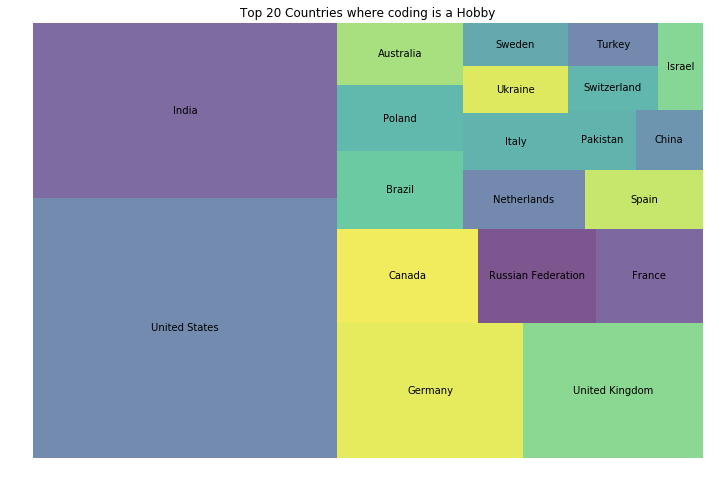

In [40]:
# Coding as Hobby
df_hobby = df_cleaned[['Country', 'Hobby']].dropna()
country = df_hobby['Country'].value_counts().index
value = df_hobby['Country'].value_counts().values
plt.figure(figsize=(12,8))
# If you have 2 lists
squarify.plot(sizes=value[:20], label=country[:20], alpha=.7)
plt.axis('off')
plt.title('Top 20 Countries where coding is a Hobby')
plt.show()

In [ ]:
# Open Source

In [ ]:
#EDUCATION

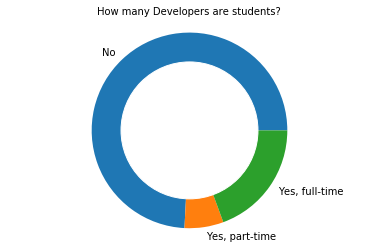

In [8]:
# How many developers are students
dev_stu = df_cleaned['Student'].dropna()
dev_student = {}
for role in dev_stu:
    dev_student[role] = (dev_student.get(role, 0)+1) 
dev_student_df = pd.DataFrame.from_dict(dev_student, orient='index',columns=['Students'])
total_developers = dev_stu.count()
dev_student_df

dev_student_df['Students'] = round(dev_student_df['Students']/total_developers*100,2)
dev_student_df['Students'].plot.pie()
plt.title('How many Developers are students?', fontsize=10)
plt.axis("equal")
plt.ylabel(" ")
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("Images/StudentDevelopers.png")

(-1.1117691655511515,
 1.1005604364548167,
 -1.109732241105186,
 1.1067785659712486)

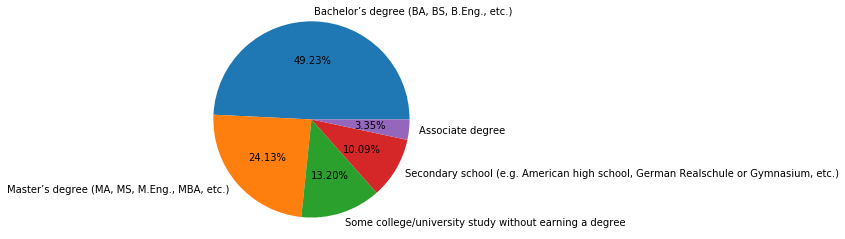

In [41]:
#Highest Degree done by Developers
degree_df = df_cleaned['FormalEducation'].dropna()
degree = degree_df.value_counts().index
count = degree_df.value_counts().values
plt.pie(x = count[:5], 
        labels = degree[:5], 
        autopct = '%.2f%%')
plt.axis('equal')

In [ ]:
# Undergrad Major


In [ ]:
# DEMOGRAPHICS

Male                                                                         59458
Female                                                                        4025
Non-binary, genderqueer, or gender non-conforming                              284
Female;Transgender                                                             145
Male;Non-binary, genderqueer, or gender non-conforming                         128
Transgender                                                                    105
Female;Male                                                                     98
Transgender;Non-binary, genderqueer, or gender non-conforming                   51
Female;Non-binary, genderqueer, or gender non-conforming                        50
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming       50
Male;Transgender                                                                29
Female;Transgender;Non-binary, genderqueer, or gender non-conforming            24
Fema

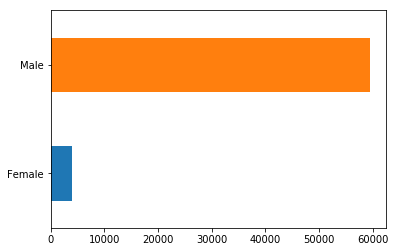

In [23]:
# Gender Analysis
gender_df = df_cleaned[['Country','Gender']].dropna()
male_female_df = gender_df['Gender'].where((gender_df['Gender'] == 'Male') | (gender_df['Gender'] == 'Female')).value_counts()
male_female_df.sort_values().plot(kind='barh')


              Country  count_female  count_male
0       United States        1288.0       13914
1               India         440.0        6213
2      United Kingdom         256.0        4260
3              Canada         208.0        2201
4             Germany         193.0        4205
5  Russian Federation          95.0        1632
6           Australia          85.0        1389
7              France          83.0        1629
8              Poland          73.0        1310
9         Netherlands          66.0        1212


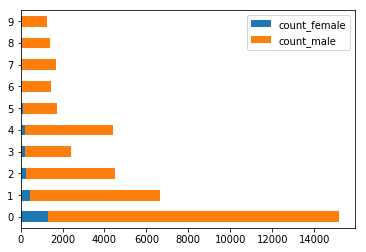

In [34]:
female_df = gender_df['Country'].loc[gender_df['Gender'] == 'Female'].value_counts()
male_df = gender_df['Country'].loc[gender_df['Gender'] == 'Male'].value_counts()
s = female_df + male_df 
male_df = pd.DataFrame({'Country':male_df.index, 'count':male_df.values})
female_df = pd.DataFrame({'Country':female_df.index, 'count':female_df.values})
gender_count_df = female_df.merge(male_df, how='outer', on='Country', suffixes=['_female','_male'])
count = gender_count_df.head(10)
print(count)
count.plot(kind='barh', stacked=True)
plt.savefig("Images/DevelopersGenderAnalysisBarChart.png")

In [42]:
# PARENTS EDUCATION LEVEL


In [43]:
# experience and gender


In [44]:
# Developer Role and Gender

In [45]:
# Age

In [46]:
# Age and Experience by Country